In [298]:
''' 1. Zipcodes to ZCTAs mapping
This script maps every US zipcode to its corresponding ZCTA as mapped
by US Bearue of Statistics

2. Socio-economic classification of Zipcodes/ZCTAs
using K-Means Clustering Algorithm by household income
''' 
# Authour Diana Kung'u

from pandas import read_csv, merge, read_excel, ExcelFile, concat, qcut, cut
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white')

In [299]:
#Read Data
zctas = read_csv('.\Input\ZCTA_Household_income.csv')

with ExcelFile(r'.\Input\ZiptoZcta_Crosswalk_2021.xlsx') as xl :
    df = concat([read_excel(xl, sheet_name = s ) for s in xl.sheet_names],
                ignore_index= True)


In [300]:
df.ZCTA = df.ZCTA.astype('str')

print(f'df.ZIP_CODE dtype: {df.ZIP_CODE.dtype}, with {df.ZIP_CODE.nunique()} unique values.')
print(f'df.ZCTA dtype: {df.ZCTA.dtype}, with {df.ZCTA.nunique()} unique values.')

df.ZIP_CODE dtype: int64, with 41107 unique values.
df.ZCTA dtype: object, with 33144 unique values.


In [301]:
#Check the length of ZCTA codes
df['len'] = df.ZCTA.str.len()
df['len'].unique() # There are  5, nan and 7 length codes
df[df['len'] == 7] # This represent 'No ZCTA' drop	
df.drop(df[df['len'] == 7].index, inplace= True)

df.ZCTA = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in df.ZCTA]

In [302]:
print(f'df.ZIP_CODE dtype: {df.ZIP_CODE.dtype}, with {df.ZIP_CODE.nunique()} unique values.')
print(f'df.ZCTA dtype: {df.ZCTA.dtype}, with {df.ZCTA.nunique()} unique values.')

df.ZIP_CODE dtype: int64, with 41099 unique values.
df.ZCTA dtype: object, with 33139 unique values.


In [303]:
zctas.ZCTA = zctas.ZCTA.astype('str')
print(f'ZCTA dtype: {zctas.ZCTA.dtype} with {zctas.ZCTA.nunique()} unique values')

# Convert all ZCTAs to 5 digit
zctas.ZCTA = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in zctas.ZCTA]


ZCTA dtype: object with 33120 unique values


In [304]:
df = df.iloc[:, [0,2,4]].copy()
df = df.drop_duplicates(keep='last')

df = df.merge(zctas, how='right', left_on= 'ZCTA', right_on= 'ZCTA')


In [305]:
#convert zip_codes to 5-digit str object
df.ZIP_CODE = df.ZIP_CODE.astype('Int64') 
df.drop(df[df.ZIP_CODE.isna()].index, inplace= True) # drop rows with missing zipcodes
df.ZIP_CODE = df.ZIP_CODE.astype('str')
df.ZIP_CODE = [c if len(c) == 5 else '0'+ c if len(c) == 4 else '00'+c 
             for c in df.ZIP_CODE]
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3
0,35007,AL,35007,2224,473,254,9,8,7
1,35137,AL,35007,2224,473,254,9,8,7
2,35144,AL,35007,2224,473,254,9,8,7
3,35124,AL,35124,2012,809,805,9,8,8
4,35173,AL,35173,2265,1037,980,9,9,9


In [306]:
df['RFM_Score'] = df[['RFM1', 'RFM2', 'RFM3']].sum(axis = 1)
df['RFM_Group'] = df['RFM1'].map(str) + df['RFM2'].map(str) + df['RFM3'].map(str)
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,RFM_Score,RFM_Group
0,35007,AL,35007,2224,473,254,9,8,7,24,987
1,35137,AL,35007,2224,473,254,9,8,7,24,987
2,35144,AL,35007,2224,473,254,9,8,7,24,987
3,35124,AL,35124,2012,809,805,9,8,8,25,988
4,35173,AL,35173,2265,1037,980,9,9,9,27,999


(array([ 7271.,  3042.,  3799.,  3492.,  3743.,  4123.,  4780., 10816.]),
 array([0.   , 1.125, 2.25 , 3.375, 4.5  , 5.625, 6.75 , 7.875, 9.   ]),
 <BarContainer object of 8 artists>)

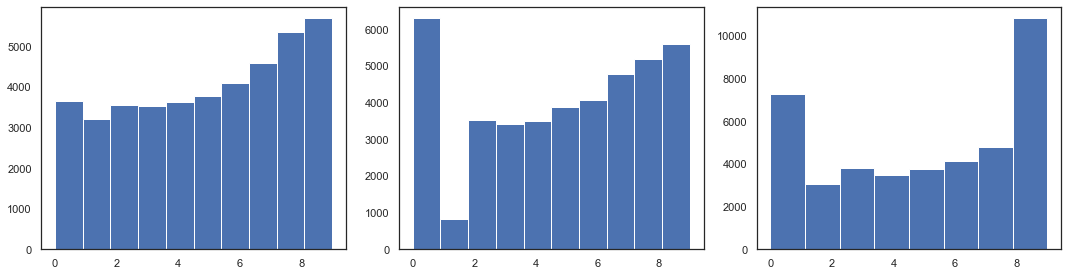

In [307]:
#Distribution of RFM 1, RFM 2 and RFM 3
figure, axs = plt.subplots(1, 3,figsize=(15, 4), facecolor='w', edgecolor='k',
                             tight_layout=True)

axs[0].hist(df.RFM1, bins=10)
axs[1].hist(df.RFM2, bins=10)
axs[2].hist(df.RFM3, bins=8)



In [308]:
df

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,RFM_Score,RFM_Group
0,35007,AL,35007,2224,473,254,9,8,7,24,987
1,35137,AL,35007,2224,473,254,9,8,7,24,987
2,35144,AL,35007,2224,473,254,9,8,7,24,987
3,35124,AL,35124,2012,809,805,9,8,8,25,988
4,35173,AL,35173,2265,1037,980,9,9,9,27,999
...,...,...,...,...,...,...,...,...,...,...,...
41066,00935,PR,00936,0,0,0,0,0,0,0,000
41067,00936,PR,00936,0,0,0,0,0,0,0,000
41068,00950,PR,00950,0,0,0,0,0,0,0,000
41069,00951,PR,00951,0,0,0,0,0,0,0,000


(array([ 7271.,     0.,     0.,  3042.,  3799.,  3492.,  7866., 15596.]),
 array([0.      , 0.287875, 0.57575 , 0.863625, 1.1515  , 1.439375,
        1.72725 , 2.015125, 2.303   ]),
 <BarContainer object of 8 artists>)

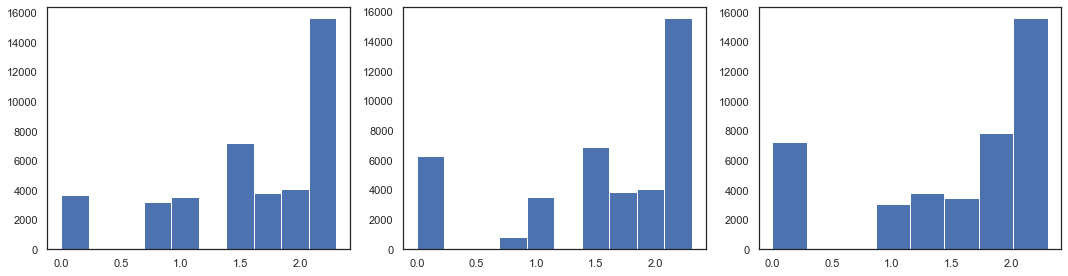

In [310]:
#Perform Log transformation to bring data into normal or near normal distribution
log_Tfd_Data = df[['RFM1', 'RFM2', 'RFM3']].apply(lambda x : np.log(x+1), axis = 1).round(3)


figure, axs = plt.subplots(1, 3,figsize=(15, 4), facecolor='w', edgecolor='k',
                             tight_layout=True)

axs[0].hist(log_Tfd_Data.RFM1, bins=10)
axs[1].hist(log_Tfd_Data.RFM2, bins=10)
axs[2].hist(log_Tfd_Data.RFM3, bins=8)


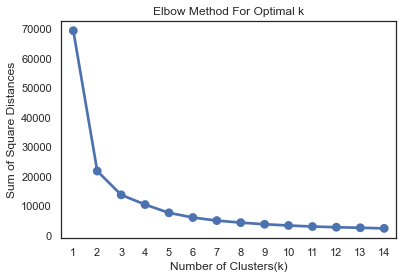

In [312]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(log_Tfd_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [319]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 5, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(log_Tfd_Data)

#Find the clusters for the observation given in the dataset
df['Cluster'] = KMean_clust.labels_
df.head()

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,RFM_Score,RFM_Group,Cluster
0,35007,AL,35007,2224,473,254,9,8,7,24,987,0
1,35137,AL,35007,2224,473,254,9,8,7,24,987,0
2,35144,AL,35007,2224,473,254,9,8,7,24,987,0
3,35124,AL,35124,2012,809,805,9,8,8,25,988,0
4,35173,AL,35173,2265,1037,980,9,9,9,27,999,0


In [320]:
df[df['Cluster']==4]

,ZIP_CODE,STATE,ZCTA,Households100to149K,Households150to199K,Households200KorMore,RFM1,RFM2,RFM3,RFM_Score,RFM_Group,Cluster
15951,95372,CA,95372,251,0,13,6,0,3,9,603,4
16219,32735,FL,32735,295,0,10,6,0,3,9,603,4
16491,61535,IL,61535,250,0,133,6,0,7,13,607,4
16651,46806,IN,46806,289,0,64,6,0,6,12,606,4
16652,46896,IN,46806,289,0,64,6,0,6,12,606,4
...,...,...,...,...,...,...,...,...,...,...,...,...
41022,82219,WY,82219,0,0,5,0,0,2,2,002,4
41045,82720,WY,82720,3,17,10,0,3,3,6,033,4
41052,82944,WY,82944,0,0,9,0,0,3,3,003,4
41056,83414,WY,83414,0,19,46,0,3,5,8,035,4


In [ ]:
df['Cluster']